## Imports and Dependencies

In [24]:
import os
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
import joblib

## Load Dataset Function

In [18]:
def load_dataset(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} does not exist")
    return pd.read_csv(path)

## Train and Evaluate Model Function

In [19]:
def train_and_evaluate(name, pipeline, param_grid, X_train, X_test, y_train, y_test, search_type="grid"):
    if search_type == "random":
        search = RandomizedSearchCV(pipeline, param_grid, n_iter=3, cv=3, scoring='f1', n_jobs=-1, random_state=42)
    else:
        search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    try:
        if hasattr(best_model.named_steps['classifier'], "predict_proba"):
            y_score = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model.named_steps['classifier'], "decision_function"):
            y_score = best_model.decision_function(X_test)
        else:
            y_score = None
        auc = roc_auc_score(y_test, y_score) if y_score is not None else "N/A"
    except Exception as e:
        auc = f"Unavailable ({e})"

    print(f"\n===== {name} Results =====")
    print("Best Params:", search.best_params_)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {auc}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()
    
    # Save the best model
    model_filename = f"{name}_best_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f" Saved best model to {model_filename}")

    return {
        "Model": name,
        "Best Params": search.best_params_,
        "AUC Value": auc
    }

## Main Function: Execute Pipeline

In [22]:
def main():
    # Load datasets
    csv_svm_mlp = os.path.join(os.getcwd(), 'mlmavericks_coursework', 'data', 'processed', 'census_income_SVM_MLP.csv')
    csv_dt = os.path.join(os.getcwd(), 'mlmavericks_coursework', 'data', 'processed', 'census_income_Decision_Tree.csv')

    df_svm_mlp = load_dataset(csv_svm_mlp)
    df_dt = load_dataset(csv_dt)
    # Dropping target variable
    X_svm_mlp = df_svm_mlp.drop('Income', axis=1)
    y_svm_mlp = df_svm_mlp['Income']
    X_dt = df_dt.drop('Income', axis=1)
    y_dt = df_dt['Income']
    # Split data into train/test sets
    
    X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm_mlp, y_svm_mlp, test_size=0.2, stratify=y_svm_mlp, random_state=42)
    X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, stratify=y_dt, random_state=42)

    # Define model configurations
    model_configs = {
        "LinearSVC": {
            "X_train": X_train_svm,
            "X_test": X_test_svm,
            "y_train": y_train_svm,
            "y_test": y_test_svm,
            "pipeline": Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', LinearSVC(class_weight='balanced', max_iter=5000, random_state=42))
            ]),
            "params": {
                'classifier__C': [0.1, 1, 10]
            },
            "search_type": "grid"
        },
        "MLP": {
            "X_train": X_train_svm,
            "X_test": X_test_svm,
            "y_train": y_train_svm,
            "y_test": y_test_svm,
            "pipeline": Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, early_stopping=True, random_state=42))
            ]),
            "params": {
                'classifier__alpha': [0.0001, 0.001],
                'classifier__learning_rate_init': [0.001, 0.01]
            },
            "search_type": "grid"
        },
        "DecisionTree": {
            "X_train": X_train_dt,
            "X_test": X_test_dt,
            "y_train": y_train_dt,
            "y_test": y_test_dt,
            "pipeline": Pipeline([
                ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
            ]),
            "params": {
                'classifier__max_depth': [5, 10, None],
                'classifier__min_samples_split': [2, 5]
            },
            "search_type": "grid"
        }
    }
    #Train and evaluate all models
    results = []
    for name, cfg in model_configs.items():
        result = train_and_evaluate(
            name,
            cfg["pipeline"],
            cfg["params"],
            cfg["X_train"],
            cfg["X_test"],
            cfg["y_train"],
            cfg["y_test"],
            cfg.get("search_type", "grid")
        )
        results.append(result)
    #Save summary results
    results_df = pd.DataFrame(results)
    results_df.to_csv("summary_results.csv", index=False)
    print("\n Summary of Model Comparisons:")
    print(results_df)
    
    # Plot bar chart: Compare ROC-AUC across models
    results_df_sorted = results_df.sort_values(by='AUC Value', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='AUC Value', y='Model', data=results_df_sorted)
    plt.title('🔍 Model Comparison by ROC-AUC')
    plt.xlabel('ROC-AUC')
    plt.ylabel('Model')
    plt.xlim(0.85, 0.89)  # optional: adjust based on your AUC range
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


## Run the script

C:\Users\ritwi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



===== LinearSVC Results =====
Best Params: {'classifier__C': 1}
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      6296
           1       0.51      0.84      0.64      1919

    accuracy                           0.78      8215
   macro avg       0.73      0.80      0.74      8215
weighted avg       0.84      0.78      0.79      8215

ROC-AUC: 0.8788549004703184


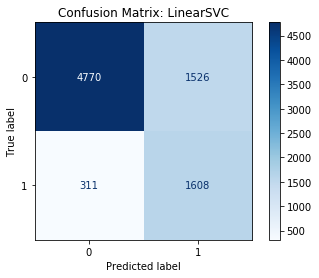

 Saved best model to LinearSVC_best_model.pkl

===== MLP Results =====
Best Params: {'classifier__alpha': 0.0001, 'classifier__learning_rate_init': 0.01}
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6296
           1       0.67      0.56      0.61      1919

    accuracy                           0.83      8215
   macro avg       0.77      0.74      0.75      8215
weighted avg       0.83      0.83      0.83      8215

ROC-AUC: 0.8820702557783365


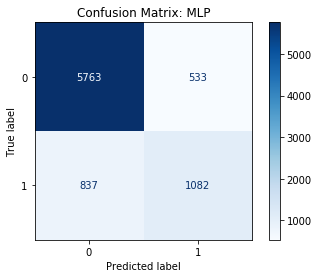

 Saved best model to MLP_best_model.pkl

===== DecisionTree Results =====
Best Params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      6296
           1       0.51      0.83      0.63      1919

    accuracy                           0.77      8215
   macro avg       0.72      0.79      0.73      8215
weighted avg       0.84      0.77      0.79      8215

ROC-AUC: 0.8642099204570359


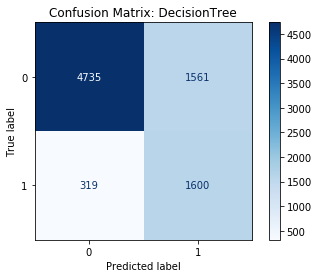

 Saved best model to DecisionTree_best_model.pkl

 Summary of Model Comparisons:
          Model                                        Best Params  AUC Value
0     LinearSVC                               {'classifier__C': 1}   0.878855
1           MLP  {'classifier__alpha': 0.0001, 'classifier__lea...   0.882070
2  DecisionTree  {'classifier__max_depth': 5, 'classifier__min_...   0.864210


C:\Users\ritwi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ritwi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56589 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ritwi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ritwi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 56589 missing from current font.
  font.set_text(s, 0, flags=flags)


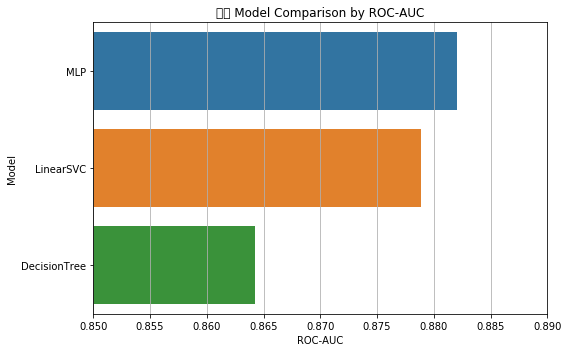

In [25]:
# Run the script
if __name__ == "__main__":
    main()


## Model Performance Summary

This section presents the performance of three machine learning models used to predict whether an individual's income exceeds $50K per year, based on census data.

### 🔍 Evaluation Metrics
Each model was assessed using the following metrics:
- **Precision**: Correctly predicted positives out of all predicted positives
- **Recall**: Correctly predicted positives out of all actual positives
- **F1-score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the Receiver Operating Characteristic curve, representing the model’s ability to distinguish between classes

### Results Comparison

| Model         | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) | ROC-AUC |
|---------------|----------|----------------------|-------------------|---------------------|---------|
| LinearSVC     | 78%      | 0.51                 | **0.84**          | 0.64                | 0.8789  |
| MLPClassifier | **83%**  | **0.67**             | 0.56              | **0.61**            | **0.8821** |
| DecisionTree  | 77%      | 0.51                 | 0.83              | 0.63                | 0.8642  |

### Conclusion and Recommendation

- **MLPClassifier** is the strongest performer overall, with the highest accuracy and ROC-AUC, making it a solid choice for deployment.
- **LinearSVC** and **DecisionTreeClassifier** achieved higher recall, which may be preferable in use cases where identifying all high-income individuals is prioritized (e.g., policy outreach).
- The final choice of model should consider whether **recall** (capturing as many true positives as possible) or **precision** (reducing false positives) is more critical in the application context.


